Simple Digit Image Generator Using GAN(Generative Adversarial Network)

1. Import Libraries

In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


-TensorFlow and Keras: Used for building and training neural networks.

-NumPy: Used for numerical operations and handling arrays.

-Matplotlib: Used for plotting and visualizing generated images.

-Load Model: Used for loading pre-trained models from disk.


2. Build the Generator Model

In [2]:

def build_generator(latent_dim, num_classes):
    noise = layers.Input(shape=(latent_dim,))
    label = layers.Input(shape=(num_classes,))
    model_input = layers.concatenate([noise, label])

    x = layers.Dense(128)(model_input)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    x = layers.Dense(28 * 28 * 1, activation='tanh')(x)
    output = layers.Reshape((28, 28, 1))(x)

    model = Model([noise, label], output)
    return model

# Define dimensions and number of classes
latent_dim = 100  # Size of the noise vector
num_classes = 10  # Number of digit classes (0-9)

# Instantiate the generator
generator = build_generator(latent_dim, num_classes)


-Latent Dimension: Represents the noise input, which is used to generate random images.
-Label Input: The digit class (0-9) that the generator should learn to produce.

3. Build the Discriminator Model

In [3]:
def build_discriminator(img_shape, num_classes):
    img = layers.Input(shape=img_shape)
    label = layers.Input(shape=(num_classes,))

    label_embedding = layers.Dense(np.prod(img_shape))(label)
    label_embedding = layers.Reshape(img_shape)(label_embedding)

    combined_input = layers.concatenate([img, label_embedding])

    x = layers.Flatten()(combined_input)
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    x = layers.Dense(1, activation='sigmoid')(x)

    model = Model([img, label], x)
    return model

# Define the image shape (28x28 pixels, 1 channel)
img_shape = (28, 28, 1)

# Instantiate the discriminator
discriminator = build_discriminator(img_shape, num_classes)
discriminator.compile(optimizer='adam', loss='binary_crossentropy')



-Image Input: The image to be classified as real or fake.

-Label Embedding: Embeds the label into the same shape as the image to combine them.

-Discriminator Output: Produces a single value, indicating whether the image is real (1) or fake (0).

4. Combine Generator and Discriminator

In [4]:
# Combine the generator and discriminator models
noise = layers.Input(shape=(latent_dim,))
label = layers.Input(shape=(num_classes,))
generated_img = generator([noise, label])
validity = discriminator([generated_img, label])

# Create the combined model to train the generator
combined = Model([noise, label], validity)
combined.compile(optimizer='adam', loss='binary_crossentropy')
combined.summary()  # Display the model architecture



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_5 (InputLayer)    │ (None, 10)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ functional (Functional)       │ (None, 28, 28, 1)         │         248,720 │ input_layer_4[0][0],       │
│                               │                           │                 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ functional_1 (Functional)     │ (None, 1)                 │         943,537 │ functional[0][0],          │
│                               │                           │                 │ input_layer_5[0][0]        │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,192,257 (4.55 MB)

 Trainable params: 1,192,257 (4.55 MB)

 Non-trainable params: 0 (0.00 B)

-Combined Model: The generator and discriminator are combined to create a model that updates the generator based on the discriminator's feedback.

5. Load and Preprocess the MNIST Dataset

In [5]:
# Load and preprocess the MNIST dataset
(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # Normalize images to [-1, 1]
X_train = np.expand_dims(X_train, axis=-1)  # Expand dimensions to match input shape of (28, 28, 1)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)  # One-hot encode the labels


-MNIST Dataset: A dataset of handwritten digits commonly used for training image processing systems.

-Normalization: Scales the pixel values to be between -1 and 1 for better training performance.

6. Train the GAN Model

In [6]:
# Training parameters
epochs = 100  # Reduced for quick demonstration
batch_size = 128  # Number of samples per gradient update

for epoch in range(epochs):
    # Training the discriminator
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs, labels = X_train[idx], y_train[idx]

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_imgs = generator.predict([noise, labels])

    valid_y = np.ones((batch_size, 1))
    fake_y = np.zeros((batch_size, 1))

    d_loss_real = discriminator.train_on_batch([imgs, labels], valid_y)
    d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake_y)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Training the generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    valid_y = np.ones((batch_size, 1))
    g_loss = combined.train_on_batch([noise, labels], valid_y)

    # Access the first element of d_loss and g_loss if they are lists
    d_loss_value = d_loss[0] if isinstance(d_loss, list) else d_loss
    g_loss_value = g_loss[0] if isinstance(g_loss, list) else g_loss

    # Print progress
    print(f'Epoch {epoch+1}/{epochs} - D loss: {d_loss_value:.4f} - G loss: {g_loss_value:.4f}')





4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100 - D loss: 0.6985 - G loss: 0.7397
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 2/100 - D loss: 0.7100 - G loss: 0.9269
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 3/100 - D loss: 0.9822 - G loss: 1.2230
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 4/100 - D loss: 1.2628 - G loss: 1.4772
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 5/100 - D loss: 1.4787 - G loss: 1.6443
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 6/100 - D loss: 1.6057 - G loss: 1.7166
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 7/100 - D loss: 1.6444 - G loss: 1.7043
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 8/100 - D loss: 1.6023 - G loss: 1.6139
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
Epoch 9/100 - D loss: 1.4952 - G loss: 1.4714
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
Epoch 10/100 - D loss: 1.3663 - G loss: 1.3374
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 11/100 - D loss: 1.2746 - G loss: 1.2548
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
Epoch 12/100 - D loss: 1.2066 -

-Training Loop: The GAN is trained over multiple epochs, updating the discriminator and generator in each iteration.

-Discriminator Training: The discriminator is trained on both real and fake images.

-Generator Training: The generator is trained to produce images that can fool the discriminator.

7. Save the Trained Models

In [7]:
# Save the models
generator.save('generator_model.keras')
discriminator.save('discriminator_model.keras')
combined.save('combined_model.keras')

print("Models saved successfully.")

Models saved successfully.


-Model Saving: Saves the generator, discriminator, and combined models for later use without retraining.

8. Load the Trained Models

In [8]:
from keras.models import load_model

# Load the models
generator = load_model('generator_model.keras')
discriminator = load_model('discriminator_model.keras')
combined = load_model('combined_model.keras')

print("Models loaded successfully.")


Models loaded successfully.


-Model Loading: Loads the saved models so they can be used for generating images or further training.

9. Generate Images with User Input

Enter the digit you want to generate (0-9):  0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


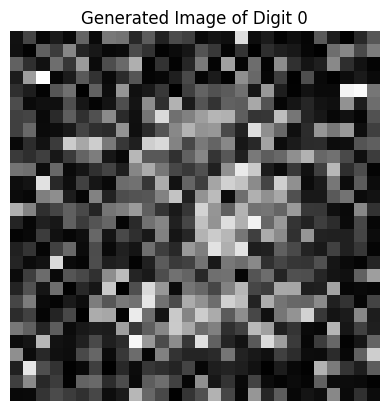

In [9]:
loaded_generator = load_model('generator_model.keras')

# Prompt the user for a digit to generate
digit = int(input("Enter the digit you want to generate (0-9): "))
label_input = np.zeros((1, num_classes))
label_input[0, digit] = 1

# Generate images with the loaded generator
noise = np.random.normal(0, 1, (1, latent_dim))  # Generate random noise
gen_img = loaded_generator.predict([noise, label_input])  # Generate image for the input digit

# Rescale the image to [0, 1]
gen_img = 0.5 * gen_img + 0.5

# Visualize the generated image
plt.imshow(gen_img[0, :, :, 0], cmap='gray')
plt.title(f'Generated Image of Digit {digit}')
plt.axis('off')
plt.show()


-User Prompt: Asks the user to input the digit they want to generate.

-Label Creation: Creates a one-hot encoded label for the input digit.

-Image Generation: Generates an image using the trained generator based on the user’s input.